In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import sys
from pathlib import Path
import os

import matplotlib.pyplot as plt
import matplotlib as mpl

# import custom functions from src folder
module_path = str(Path.cwd() / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from util import *

In [47]:
#Data constants
R2 = 3
k_red = 7
k_blue = 3
R1_min = 6
scale = 1
vary_a1 = False
vary_R2 = False
p_red = 0.5
polar = False
tag = f'r2_{R2}_kr{k_red}_kb{k_blue}_r1min{R1_min}_s{scale}_vary_r2_{vary_R2}_vary_a1_{vary_a1}_pRed_{p_red}'

trainfile = f"train_n_50000_{tag}"
testfile = f"test_n_10000_{tag}"

model_names = ["NNE", "MCD", "BNN", "GP", "MM"]
pred_keys = ["Prediction_ensemble", "Prediction_MC", "Prediction", "Prediction", "Inferred_class"]
prob_keys = ["Confidence_avg", "Confidence_MC", "Est_prob_blue", "Est_prob_blue", "Est_prob_blue"]
std_keys = ["Confidence_std", "Std_MC", "Std_prob_blue", "Sigmoid_std_logit_blue", "Std_samples_blue"]
n_models = len(model_names)
train_data = [250, 5000, 10000]
n_plots = len(train_data)

truthfile = f"analytical_solution_x1_x2_grid_{tag}_nr1MC_4000"
truthfile_test = "analytical_solution_test_n_10000_r2_3_kr7_kb3_r1min6_s1_vary_r2_False_vary_a1_False_pRed_0.5_nr1MC_8000"
truth_data = pd.read_csv(f"analytical/results/{truthfile}.csv")
truth_data = truth_data[truth_data["r_x"] > R1_min-R2] # Remove undefined area
truth_test_data = pd.read_csv(f"analytical/results/{truthfile_test}.csv")

max_err_val = [0]*n_plots
for i in range(len(train_data)):
    if train_data[i] < 1000:
        max_err_val[i] = 0.5
    else:
        max_err_val[i] = 0.25

bnn_lr_list = [0.028, 0.05, 0.05]

#pd.read_csv("DNN/predictions/train_n_50000_r2_3_kr7_kb3_r1min6_s1_vary_r2_False_vary_a1_False_pRed_0.5/grid_r2_3_kr7_kb3_r1min6_s1_vary_r2_False_vary_a1_False_pRed_0.5_predicted_SequentialNet_10ensembles_ndata-100.csv")

gridfiles = [
    [f"DNN/predictions/{trainfile}/grid_{tag}_predicted_SequentialNet_10ensembles_ndata-{n}.csv" for n in train_data],
    [f"DNN/predictions/{trainfile}/grid_{tag}_predicted_SequentialNet_MCD_pd0.3_nMC_200_Vndata-{n}.csv" for n in train_data],
    [f"BNN/predictions/{trainfile}/grid_{tag}_predicted_BNN_lr{lr}_sp0.05_ndata-{n}.csv" for (lr, n) in zip(bnn_lr_list, train_data)],
    [f"gaussian_process/predictions/{trainfile}/grid_{tag}_predicted_latentGP_0.5_ls0.2_ndata-{n}.csv" for n in train_data],
    [f"inferno/predictions/{trainfile}/grid_{tag}_predicted_MM_nsamples1200_nchains10_ndata-{n}.csv" for n in train_data]
]

testfiles = [
    [f"DNN/predictions/{trainfile}/{testfile}_predicted_SequentialNet_10ensembles_ndata-{n}.csv" for n in train_data],
    [f"DNN/predictions/{trainfile}/{testfile}_predicted_SequentialNet_MCD_pd0.3_nMC_200_Vndata-{n}.csv" for n in train_data],
    [f"BNN/predictions/{trainfile}/{testfile}_predicted_BNN_lr{lr}_sp0.05_ndata-{n}.csv" for (lr, n) in zip(bnn_lr_list, train_data)],
    [f"gaussian_process/predictions/{trainfile}/{testfile}_predicted_latentGP_0.5_ls0.2_ndata-{n}.csv" for n in train_data],
    [f"inferno/predictions/{trainfile}/{testfile}_predicted_MM_nsamples1200_nchains10_ndata-{n}.csv" for n in train_data]
]

grid_dfs = [[pd.read_csv(gridfiles[i][j]) for j in range(n_plots)]for i in range(n_models)]
test_dfs = [[pd.read_csv(testfiles[i][j]) for j in range(n_plots)]for i in range(n_models)]

for i in range(n_plots):
    test_dfs[2][i]["class"] = test_dfs[0][i]["class"]

scores = [calculate_metrics(test_dfs[i], grid_dfs[i], train_data, truth_data, truth_test_data, 
                           pred_keys[i], prob_keys[i], std_keys[i]) for i in range(n_models) for i in range(n_models)]

In [48]:
scores[-3]

,N data,ACC,ROCAUC,WD test,WD grid,Avg UE,Std UE,Mean KL-div test,Mean KL-div grid,LogLoss,ECE,MCE,RMSCE
0,250,0.7241,0.807778,0.041829,0.030536,0.093070,0.036235,0.023173,0.011706,0.531715,0.032131,0.091194,0.041229
1,5000,0.7343,0.816364,0.031829,0.013727,0.042708,0.016399,0.017823,0.003581,0.520056,0.031691,0.088370,0.044372
2,10000,0.7408,0.819802,0.028774,0.019146,0.036486,0.015986,0.015484,0.004057,0.515260,0.027007,0.081340,0.035974


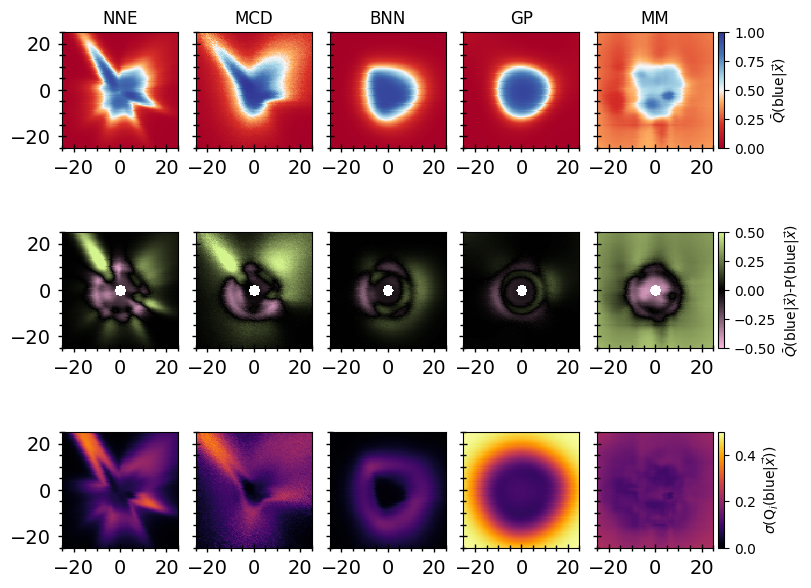

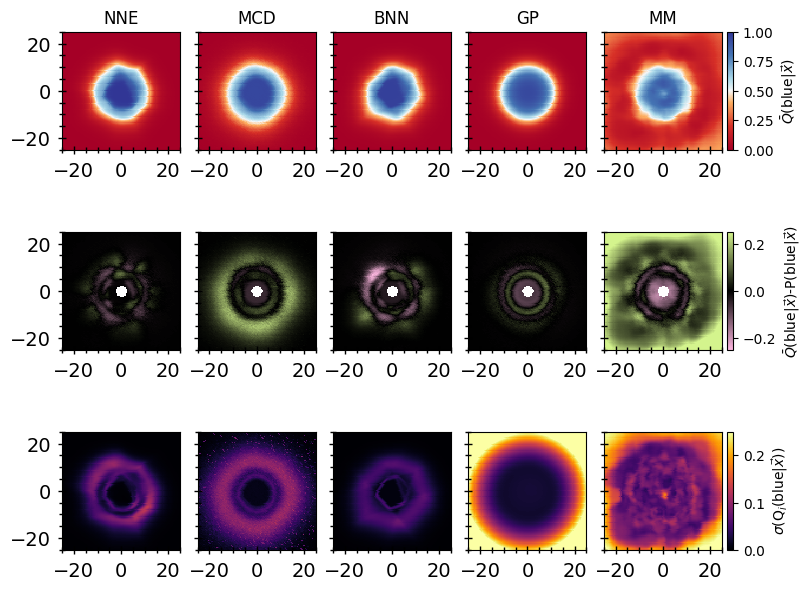

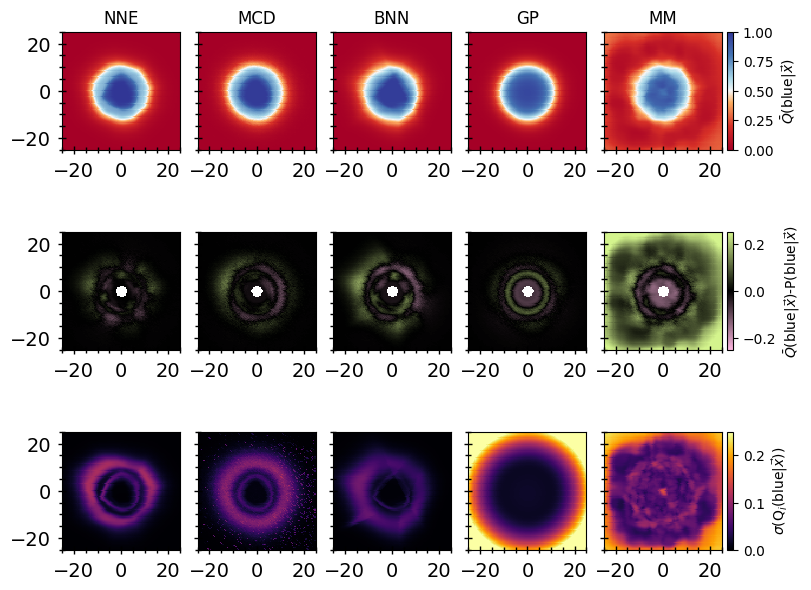

In [49]:
for i in range(n_plots):
    fig, axs = plt.subplots(nrows = 3, ncols = n_models, figsize = (8,6), layout="constrained", sharey=True)
    for j in range(n_models):
        axs[0][j] = plot_results(grid_dfs[j][i], prob_keys[j], axs[0][j], "", grid=True)
        axs[1][j] = plot_diff(grid_dfs[j][i], truth_data, prob_keys[j], "P_blue_given_x",  axs[1][j], r"", max_val=max_err_val[i])
        axs[2][j] = plot_std(grid_dfs[j][i], std_keys[j], axs[2][j], r"", grid=True, max_val=max_err_val[i])
        
        axs[0][j].set_title(model_names[j])

    hue_norm_prob = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm_prob, cmap=red_blue_cmap()),  fraction=0.050, pad=0.04,
                 label=r"$\bar{Q}$(blue|$\vec{x}$)", ax=axs[0][-1])
    
    hue_norm_err = mpl.colors.Normalize(vmin=0, vmax=max_err_val[i], clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm_err, cmap="inferno"),  fraction=0.050, pad=0.04,
                label=r"$\sigma$(Q$_i$(blue|$\vec{x}$))", ax=axs[2][-1])
    
    hue_norm_std = mpl.colors.Normalize(vmin=-max_err_val[i], vmax=max_err_val[i], clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm_std, cmap=pink_black_green_cmap()),  fraction=0.050, pad=0.04,
                 label=r"$\bar{Q}$(blue|$\vec{x}$)-P(blue|$\vec{x}$)", ax=axs[1][-1])
    

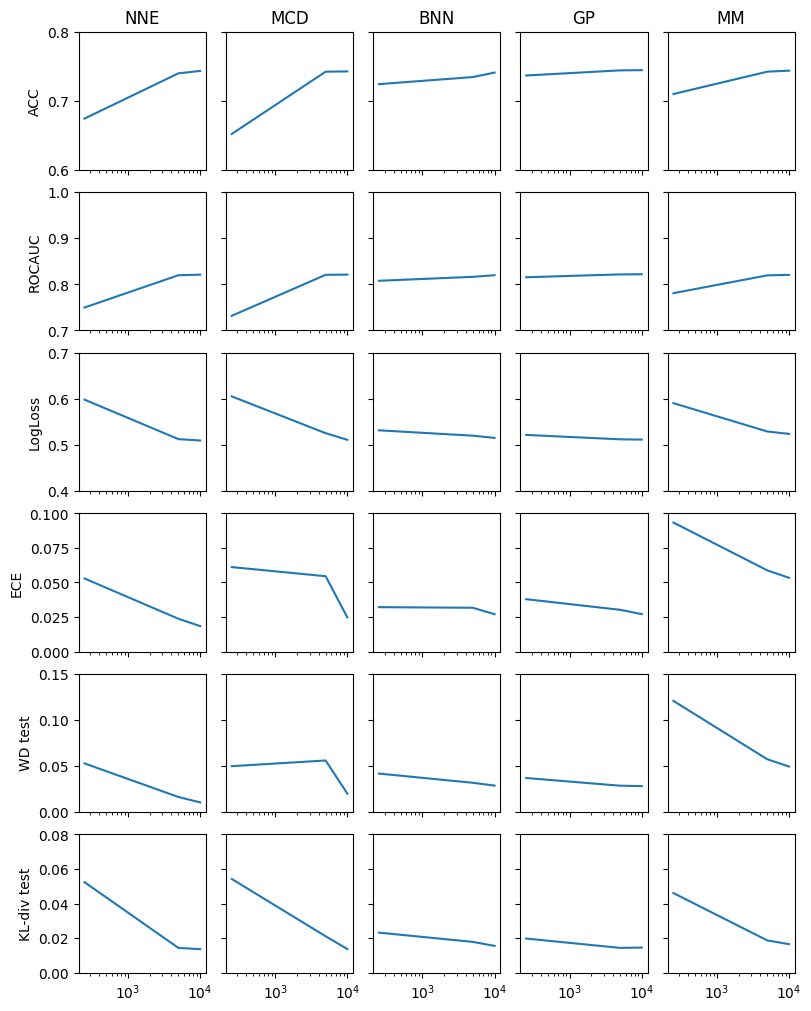

In [51]:
fig, axs = plt.subplots(nrows = 6, ncols = n_models, figsize = (8,10), layout="constrained", sharex=True, sharey="row")
for i in range(n_models):
    axs[0][i].set_title(model_names[i])
    
    axs[0][i].plot(scores[i]["N data"], scores[i]["ACC"])
    axs[0][i].set_ylim(0.6, 0.8)
    axs[0][0].set_ylabel("ACC")

    axs[1][i].plot(scores[i]["N data"], scores[i]["ROCAUC"])
    axs[1][i].set_ylim(0.7, 1)
    axs[1][0].set_ylabel("ROCAUC")

    axs[2][i].plot(scores[i]["N data"], scores[i]["LogLoss"])
    axs[2][i].set_ylim(0.4, 0.7)
    axs[2][0].set_ylabel("LogLoss")

    axs[3][i].plot(scores[i]["N data"], scores[i]["ECE"])
    axs[3][i].set_ylim(0, 0.1)
    axs[3][0].set_ylabel("ECE")

    axs[4][i].plot(scores[i]["N data"], scores[i]["WD test"])
    axs[4][i].set_ylim(0, 0.15)
    axs[4][0].set_ylabel("WD test")

    axs[5][i].plot(scores[i]["N data"], scores[i]["Mean KL-div test"])
    axs[5][i].set_ylim(0, 0.08)
    axs[5][0].set_ylabel("KL-div test")

    for ax in axs.flatten():
        ax.set_xscale("log")